# Set Parameter
- Attention = Luong
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Batch size = 32
- Drop out = 0.2
- Hidden unit = [2, 50]
- Length = [2, 100, 4]
- Epochs = 100
- N = 100
- Data = 100K
- Deduplication

# Import packages

import useful packages for experiments

In [1]:
import os
import argparse
import logging
import sys

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))))))

from trainer.supervised_trainer_without_eval import SupervisedTrainer_without_eval
from models.encoderRNN import EncoderRNN
from models.decoderRNN import DecoderRNN
from models.seq2seq import Seq2seq
from loss.loss import Perplexity
from optim.optim import Optimizer
from dataset import fields
from evaluator.evaluator import Evaluator

import matplotlib.pyplot as plt

/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


# Log format

In [2]:
log_level = 'info'
LOG_FORMAT = '%(asctime)s %(levelname)-6s %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, log_level.upper()))

# Data load

In [3]:
train_path = "../../../data/bracket_dedup/K100/data_train.txt"

# Prepare dataset

In [4]:
src = fields.SourceField()
tgt = fields.TargetField()
max_len = 104
def len_filter(example):
    return len(example.src) <= max_len and len(example.tgt) <= max_len
train = torchtext.data.TabularDataset(
    path=train_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)
src.build_vocab(train)
tgt.build_vocab(train)
input_vocab = src.vocab
output_vocab = tgt.vocab

# Prepare loss

In [5]:
weight = torch.ones(len(tgt.vocab))
pad = tgt.vocab.stoi[tgt.pad_token]
loss = Perplexity(weight, pad)
if torch.cuda.is_available():
    loss.cuda()

/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


# Variable definition

In [6]:
optimizer = "Adam"
hidden_sizes = list(range(2, 51, 4))
length_list = []
bidirectional = True
print(hidden_sizes)
evaluator = Evaluator(loss=loss, batch_size=32)

[2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50]


In [7]:
for i in hidden_sizes:
    hidden_size = i
    print("hidden size is : %d" % hidden_size)
    seq2seq = None
    encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                         bidirectional=bidirectional, variable_lengths=True)
    decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                         dropout_p=0.2, use_attention="Luong", bidirectional=bidirectional,
                         eos_id=tgt.eos_id, sos_id=tgt.sos_id)
    seq2seq = Seq2seq(encoder, decoder)
    if torch.cuda.is_available():
        seq2seq.cuda()

    for param in seq2seq.parameters():
        param.data.uniform_(-0.08, 0.08)

    # train
    t = SupervisedTrainer_without_eval(loss=loss, batch_size=32,
                                       checkpoint_every=50,
                                       print_every=100,
                                       hidden_size=hidden_size,
                                       path=str(hidden_size))

    seq2seq, ave_loss = t.train(seq2seq, train,
                                num_epochs=100, dev_data=None,
                                optimizer=optimizer,
                                teacher_forcing_ratio=0.5)
    
    lengths = list(range(98, 0, -4))
    print(lengths)
    for length in lengths:
        dev_path = "../../../data/bracket_dedup/K100/dev_length/data_test_length_" + str(length) + ".txt"
        dev = torchtext.data.TabularDataset(
              path=dev_path, format='tsv',
              fields=[('src', src), ('tgt', tgt)],
              filter_pred=len_filter)
        dev_loss, character_accuracy, sentence_accuracy = evaluator.evaluate(seq2seq, dev)
        print("Length:%d, Dev Loss:%0.4f, Character Accuracy:%0.4f, Sentence Accuracy:%0.4f\n"
                    % (length, dev_loss, character_accuracy, sentence_accuracy))
        check_path = "../../../log/check_point/bracket_dedup_hidden_size_to_length/hidden_size_" + str(hidden_size)
        with open(check_path, 'a') as f:
            f.write("Length:%d, Dev Loss:%0.4f, Character Accuracy:%0.4f, Sentence Accuracy:%0.4f\n"
                    % (length, dev_loss, character_accuracy, sentence_accuracy))
        
        if character_accuracy >= 0.95:
            length_list.append(length)
            break
        if length == 2:
            length_list.append(length)

/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
2019-03-28 12:57:15,822 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


hidden size is : 2


/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
2019-03-28 12:59:52,515 INFO   Finished epoch 1: Train loss: 20.9254
2019-03-28 13:02:27,007 INFO   Finished epoch 2: Train loss: 16.6350
2019-03-28 13:05:00,267 INFO   Finished epoch 3: Train loss: 19.2756
2019-03-28 13:07:33,578 INFO   Finished epoch 4: Train loss: 22.9415
2019-03-28 13:10:06,334 INFO   Finished epoch 5: Train loss: 25.0591
2019-03-28 13:12:40,764 INFO   Finished epoch 6: Train loss: 18.2386
2019-03-28 13:15:14,878 INFO   Finished epoch 7: Train loss: 13.9172
2019-03-28 13:17:50,783 INFO   Finished epoch 8: Train loss: 15.7509
2019-03-28 13:20:25,738 INFO   Finished epoch 9: Train loss: 14.1043
2019-03-28 13:23:00,983 INFO   Finished epoch 10: Train loss: 15.8713
2019-03-28 13:25:33,706 INFO   Finished epoch 11: Train loss: 15.1439
2019

[98, 94, 90, 86, 82, 78, 74, 70, 66, 62, 58, 54, 50, 46, 42, 38, 34, 30, 26, 22, 18, 14, 10, 6, 2]
Length:98, Dev Loss:10.3988, Character Accuracy:0.2902, Sentence Accuracy:0.0000

Length:94, Dev Loss:8.9583, Character Accuracy:0.3094, Sentence Accuracy:0.0000

Length:90, Dev Loss:8.2303, Character Accuracy:0.3254, Sentence Accuracy:0.0000

Length:86, Dev Loss:7.5389, Character Accuracy:0.3439, Sentence Accuracy:0.0000

Length:82, Dev Loss:7.2428, Character Accuracy:0.3563, Sentence Accuracy:0.0000

Length:78, Dev Loss:6.9576, Character Accuracy:0.3667, Sentence Accuracy:0.0000

Length:74, Dev Loss:6.7205, Character Accuracy:0.3797, Sentence Accuracy:0.0000

Length:70, Dev Loss:6.6240, Character Accuracy:0.3855, Sentence Accuracy:0.0000

Length:66, Dev Loss:6.2605, Character Accuracy:0.3966, Sentence Accuracy:0.0000

Length:62, Dev Loss:6.1149, Character Accuracy:0.4040, Sentence Accuracy:0.0000

Length:58, Dev Loss:5.9138, Character Accuracy:0.4113, Sentence Accuracy:0.0000

Length:54

2019-03-28 17:21:32,672 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Length:10, Dev Loss:1.8584, Character Accuracy:0.6809, Sentence Accuracy:0.0000

Length:6, Dev Loss:1.6182, Character Accuracy:0.7429, Sentence Accuracy:0.0000

Length:2, Dev Loss:1.4956, Character Accuracy:0.6667, Sentence Accuracy:0.0000

hidden size is : 6


2019-03-28 17:23:59,165 INFO   Finished epoch 1: Train loss: 19.6179
2019-03-28 17:26:31,862 INFO   Finished epoch 2: Train loss: 17.8916
2019-03-28 17:29:02,660 INFO   Finished epoch 3: Train loss: 16.8451
2019-03-28 17:31:30,434 INFO   Finished epoch 4: Train loss: 17.6652
2019-03-28 17:34:06,387 INFO   Finished epoch 5: Train loss: 14.3442
2019-03-28 17:36:40,086 INFO   Finished epoch 6: Train loss: 15.0741
2019-03-28 17:39:13,191 INFO   Finished epoch 7: Train loss: 12.4995
2019-03-28 17:41:44,754 INFO   Finished epoch 8: Train loss: 10.9933
2019-03-28 17:44:18,884 INFO   Finished epoch 9: Train loss: 9.9316
2019-03-28 17:46:53,203 INFO   Finished epoch 10: Train loss: 9.7009
2019-03-28 17:49:27,194 INFO   Finished epoch 11: Train loss: 9.5150
2019-03-28 17:52:02,451 INFO   Finished epoch 12: Train loss: 7.9889
2019-03-28 17:54:35,493 INFO   Finished epoch 13: Train loss: 7.5252
2019-03-28 17:57:10,240 INFO   Finished epoch 14: Train loss: 6.1465
2019-03-28 17:59:47,156 INFO   Fini

[98, 94, 90, 86, 82, 78, 74, 70, 66, 62, 58, 54, 50, 46, 42, 38, 34, 30, 26, 22, 18, 14, 10, 6, 2]
Length:98, Dev Loss:11.1682, Character Accuracy:0.2607, Sentence Accuracy:0.0000

Length:94, Dev Loss:8.9862, Character Accuracy:0.2843, Sentence Accuracy:0.0000

Length:90, Dev Loss:7.9975, Character Accuracy:0.3070, Sentence Accuracy:0.0000

Length:86, Dev Loss:6.9765, Character Accuracy:0.3304, Sentence Accuracy:0.0000

Length:82, Dev Loss:6.4604, Character Accuracy:0.3472, Sentence Accuracy:0.0000

Length:78, Dev Loss:5.9369, Character Accuracy:0.3651, Sentence Accuracy:0.0000

Length:74, Dev Loss:5.5150, Character Accuracy:0.3856, Sentence Accuracy:0.0000

Length:70, Dev Loss:5.2221, Character Accuracy:0.4009, Sentence Accuracy:0.0000

Length:66, Dev Loss:4.8528, Character Accuracy:0.4242, Sentence Accuracy:0.0000

Length:62, Dev Loss:4.6273, Character Accuracy:0.4442, Sentence Accuracy:0.0000

Length:58, Dev Loss:4.3934, Character Accuracy:0.4618, Sentence Accuracy:0.0000

Length:54

2019-03-28 21:41:51,155 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Length:10, Dev Loss:1.0730, Character Accuracy:0.9831, Sentence Accuracy:0.8144

hidden size is : 10


2019-03-28 21:44:20,992 INFO   Finished epoch 1: Train loss: 18.4267
2019-03-28 21:46:50,029 INFO   Finished epoch 2: Train loss: 14.7294
2019-03-28 21:49:24,574 INFO   Finished epoch 3: Train loss: 8.5571
2019-03-28 21:52:00,146 INFO   Finished epoch 4: Train loss: 6.5149
2019-03-28 21:54:34,598 INFO   Finished epoch 5: Train loss: 5.1189
2019-03-28 21:57:06,611 INFO   Finished epoch 6: Train loss: 4.1647
2019-03-28 21:59:33,750 INFO   Finished epoch 7: Train loss: 4.0031
2019-03-28 22:02:07,304 INFO   Finished epoch 8: Train loss: 3.7891
2019-03-28 22:04:43,008 INFO   Finished epoch 9: Train loss: 3.5466
2019-03-28 22:07:17,535 INFO   Finished epoch 10: Train loss: 3.2744
2019-03-28 22:09:53,550 INFO   Finished epoch 11: Train loss: 3.1583
2019-03-28 22:12:26,914 INFO   Finished epoch 12: Train loss: 2.9954
2019-03-28 22:15:02,251 INFO   Finished epoch 13: Train loss: 2.9101
2019-03-28 22:17:40,261 INFO   Finished epoch 14: Train loss: 2.9289
2019-03-28 22:20:16,214 INFO   Finished e

[98, 94, 90, 86, 82, 78, 74, 70, 66, 62, 58, 54, 50, 46, 42, 38, 34, 30, 26, 22, 18, 14, 10, 6, 2]
Length:98, Dev Loss:2.3253, Character Accuracy:0.6412, Sentence Accuracy:0.0000

Length:94, Dev Loss:2.2710, Character Accuracy:0.6491, Sentence Accuracy:0.0000

Length:90, Dev Loss:2.2252, Character Accuracy:0.6540, Sentence Accuracy:0.0000

Length:86, Dev Loss:2.1720, Character Accuracy:0.6618, Sentence Accuracy:0.0000

Length:82, Dev Loss:2.1305, Character Accuracy:0.6696, Sentence Accuracy:0.0000

Length:78, Dev Loss:2.0680, Character Accuracy:0.6812, Sentence Accuracy:0.0000

Length:74, Dev Loss:2.0251, Character Accuracy:0.6922, Sentence Accuracy:0.0000

Length:70, Dev Loss:1.9783, Character Accuracy:0.7013, Sentence Accuracy:0.0000

Length:66, Dev Loss:1.9239, Character Accuracy:0.7145, Sentence Accuracy:0.0000

Length:62, Dev Loss:1.8758, Character Accuracy:0.7256, Sentence Accuracy:0.0000

Length:58, Dev Loss:1.8105, Character Accuracy:0.7414, Sentence Accuracy:0.0000

Length:54,

2019-03-29 02:03:54,247 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Length:22, Dev Loss:1.1196, Character Accuracy:0.9565, Sentence Accuracy:0.5720

hidden size is : 14


2019-03-29 02:06:29,246 INFO   Finished epoch 1: Train loss: 17.6489
2019-03-29 02:08:58,479 INFO   Finished epoch 2: Train loss: 14.1066
2019-03-29 02:11:31,841 INFO   Finished epoch 3: Train loss: 8.8303
2019-03-29 02:14:08,541 INFO   Finished epoch 4: Train loss: 3.9563
2019-03-29 02:16:44,323 INFO   Finished epoch 5: Train loss: 3.3725
2019-03-29 02:19:18,833 INFO   Finished epoch 6: Train loss: 3.0358
2019-03-29 02:21:52,097 INFO   Finished epoch 7: Train loss: 2.8238
2019-03-29 02:24:30,789 INFO   Finished epoch 8: Train loss: 2.7628
2019-03-29 02:27:05,940 INFO   Finished epoch 9: Train loss: 2.5947
2019-03-29 02:29:37,851 INFO   Finished epoch 10: Train loss: 2.5532
2019-03-29 02:32:06,413 INFO   Finished epoch 11: Train loss: 2.4271
2019-03-29 02:34:42,780 INFO   Finished epoch 12: Train loss: 2.4098
2019-03-29 02:37:17,112 INFO   Finished epoch 13: Train loss: 2.3310
2019-03-29 02:39:52,991 INFO   Finished epoch 14: Train loss: 2.3121
2019-03-29 02:42:29,647 INFO   Finished e

[98, 94, 90, 86, 82, 78, 74, 70, 66, 62, 58, 54, 50, 46, 42, 38, 34, 30, 26, 22, 18, 14, 10, 6, 2]
Length:98, Dev Loss:1.5300, Character Accuracy:0.8226, Sentence Accuracy:0.0000

Length:94, Dev Loss:1.4628, Character Accuracy:0.8428, Sentence Accuracy:0.0000

Length:90, Dev Loss:1.4158, Character Accuracy:0.8576, Sentence Accuracy:0.0000

Length:86, Dev Loss:1.3627, Character Accuracy:0.8749, Sentence Accuracy:0.0000

Length:82, Dev Loss:1.3157, Character Accuracy:0.8893, Sentence Accuracy:0.0002

Length:78, Dev Loss:1.2692, Character Accuracy:0.9044, Sentence Accuracy:0.0013

Length:74, Dev Loss:1.2268, Character Accuracy:0.9169, Sentence Accuracy:0.0052

Length:70, Dev Loss:1.1847, Character Accuracy:0.9318, Sentence Accuracy:0.0157

Length:66, Dev Loss:1.1501, Character Accuracy:0.9439, Sentence Accuracy:0.0547



2019-03-29 06:25:42,136 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Length:62, Dev Loss:1.1320, Character Accuracy:0.9505, Sentence Accuracy:0.0760

hidden size is : 18


2019-03-29 06:28:19,413 INFO   Finished epoch 1: Train loss: 17.8307
2019-03-29 06:30:53,893 INFO   Finished epoch 2: Train loss: 9.6055
2019-03-29 06:33:23,853 INFO   Finished epoch 3: Train loss: 4.0375
2019-03-29 06:35:56,972 INFO   Finished epoch 4: Train loss: 3.1244
2019-03-29 06:38:32,218 INFO   Finished epoch 5: Train loss: 2.8151
2019-03-29 06:41:09,742 INFO   Finished epoch 6: Train loss: 2.6333
2019-03-29 06:43:46,130 INFO   Finished epoch 7: Train loss: 2.4443
2019-03-29 06:46:20,734 INFO   Finished epoch 8: Train loss: 2.3025
2019-03-29 06:48:58,079 INFO   Finished epoch 9: Train loss: 2.1824
2019-03-29 06:51:36,341 INFO   Finished epoch 10: Train loss: 2.0839
2019-03-29 06:54:10,793 INFO   Finished epoch 11: Train loss: 2.0294
2019-03-29 06:56:49,468 INFO   Finished epoch 12: Train loss: 1.9709
2019-03-29 06:59:25,834 INFO   Finished epoch 13: Train loss: 1.9138
2019-03-29 07:02:00,408 INFO   Finished epoch 14: Train loss: 1.8506
2019-03-29 07:04:30,288 INFO   Finished ep

[98, 94, 90, 86, 82, 78, 74, 70, 66, 62, 58, 54, 50, 46, 42, 38, 34, 30, 26, 22, 18, 14, 10, 6, 2]
Length:98, Dev Loss:1.1873, Character Accuracy:0.9319, Sentence Accuracy:0.0070

Length:94, Dev Loss:1.1429, Character Accuracy:0.9471, Sentence Accuracy:0.0249



2019-03-29 10:47:47,670 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Length:90, Dev Loss:1.1085, Character Accuracy:0.9595, Sentence Accuracy:0.0715

hidden size is : 22


2019-03-29 10:50:23,891 INFO   Finished epoch 1: Train loss: 17.9519
2019-03-29 10:53:01,692 INFO   Finished epoch 2: Train loss: 8.0389
2019-03-29 10:55:41,141 INFO   Finished epoch 3: Train loss: 4.0527
2019-03-29 10:58:23,559 INFO   Finished epoch 4: Train loss: 3.3134
2019-03-29 11:00:52,995 INFO   Finished epoch 5: Train loss: 2.7984
2019-03-29 11:03:34,856 INFO   Finished epoch 6: Train loss: 2.6532
2019-03-29 11:06:17,992 INFO   Finished epoch 7: Train loss: 2.4378
2019-03-29 11:08:57,777 INFO   Finished epoch 8: Train loss: 2.2848
2019-03-29 11:11:35,918 INFO   Finished epoch 9: Train loss: 2.1600
2019-03-29 11:14:13,065 INFO   Finished epoch 10: Train loss: 2.0647
2019-03-29 11:16:53,479 INFO   Finished epoch 11: Train loss: 1.9977
2019-03-29 11:19:29,269 INFO   Finished epoch 12: Train loss: 1.8937
2019-03-29 11:22:09,512 INFO   Finished epoch 13: Train loss: 1.8719
2019-03-29 11:24:45,737 INFO   Finished epoch 14: Train loss: 1.8076
2019-03-29 11:27:25,656 INFO   Finished ep

[98, 94, 90, 86, 82, 78, 74, 70, 66, 62, 58, 54, 50, 46, 42, 38, 34, 30, 26, 22, 18, 14, 10, 6, 2]


2019-03-29 15:10:48,552 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Length:98, Dev Loss:1.0572, Character Accuracy:0.9781, Sentence Accuracy:0.1873

hidden size is : 26


2019-03-29 15:13:26,284 INFO   Finished epoch 1: Train loss: 17.6120
2019-03-29 15:16:06,949 INFO   Finished epoch 2: Train loss: 6.3409
2019-03-29 15:18:45,827 INFO   Finished epoch 3: Train loss: 3.5852
2019-03-29 15:21:24,549 INFO   Finished epoch 4: Train loss: 3.0284
2019-03-29 15:24:03,924 INFO   Finished epoch 5: Train loss: 2.7649
2019-03-29 15:26:52,461 INFO   Finished epoch 6: Train loss: 2.5411
2019-03-29 15:29:35,127 INFO   Finished epoch 7: Train loss: 2.2891
2019-03-29 15:32:16,711 INFO   Finished epoch 8: Train loss: 2.1216
2019-03-29 15:34:57,762 INFO   Finished epoch 9: Train loss: 1.9958
2019-03-29 15:37:39,030 INFO   Finished epoch 10: Train loss: 1.9174
2019-03-29 15:40:18,476 INFO   Finished epoch 11: Train loss: 1.8264
2019-03-29 15:42:58,785 INFO   Finished epoch 12: Train loss: 1.7649
2019-03-29 15:45:38,975 INFO   Finished epoch 13: Train loss: 1.6935
2019-03-29 15:48:20,933 INFO   Finished epoch 14: Train loss: 1.6738
2019-03-29 15:51:07,952 INFO   Finished ep

[98, 94, 90, 86, 82, 78, 74, 70, 66, 62, 58, 54, 50, 46, 42, 38, 34, 30, 26, 22, 18, 14, 10, 6, 2]


2019-03-29 19:39:59,538 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Length:98, Dev Loss:1.0444, Character Accuracy:0.9853, Sentence Accuracy:0.3441

hidden size is : 30


2019-03-29 19:42:39,054 INFO   Finished epoch 1: Train loss: 15.2810
2019-03-29 19:45:13,075 INFO   Finished epoch 2: Train loss: 6.3345
2019-03-29 19:47:53,522 INFO   Finished epoch 3: Train loss: 3.6697
2019-03-29 19:50:33,421 INFO   Finished epoch 4: Train loss: 2.6557
2019-03-29 19:53:14,804 INFO   Finished epoch 5: Train loss: 2.2754
2019-03-29 19:55:55,629 INFO   Finished epoch 6: Train loss: 2.0048
2019-03-29 19:58:34,783 INFO   Finished epoch 7: Train loss: 1.8734
2019-03-29 20:01:12,373 INFO   Finished epoch 8: Train loss: 1.7102
2019-03-29 20:03:51,679 INFO   Finished epoch 9: Train loss: 1.6122
2019-03-29 20:06:30,921 INFO   Finished epoch 10: Train loss: 1.5188
2019-03-29 20:09:14,409 INFO   Finished epoch 11: Train loss: 1.4484
2019-03-29 20:11:53,417 INFO   Finished epoch 12: Train loss: 1.3665
2019-03-29 20:14:32,857 INFO   Finished epoch 13: Train loss: 1.3157
2019-03-29 20:17:12,365 INFO   Finished epoch 14: Train loss: 1.2465
2019-03-29 20:19:49,251 INFO   Finished ep

[98, 94, 90, 86, 82, 78, 74, 70, 66, 62, 58, 54, 50, 46, 42, 38, 34, 30, 26, 22, 18, 14, 10, 6, 2]


2019-03-30 00:05:37,105 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Length:98, Dev Loss:1.0074, Character Accuracy:0.9989, Sentence Accuracy:0.9838

hidden size is : 34


2019-03-30 00:08:13,396 INFO   Finished epoch 1: Train loss: 19.4972
2019-03-30 00:10:52,870 INFO   Finished epoch 2: Train loss: 8.2361
2019-03-30 00:13:32,842 INFO   Finished epoch 3: Train loss: 4.6314
2019-03-30 00:16:12,482 INFO   Finished epoch 4: Train loss: 3.0548
2019-03-30 00:18:50,920 INFO   Finished epoch 5: Train loss: 2.3952
2019-03-30 00:21:30,718 INFO   Finished epoch 6: Train loss: 2.0354
2019-03-30 00:24:11,981 INFO   Finished epoch 7: Train loss: 1.8129
2019-03-30 00:26:52,033 INFO   Finished epoch 8: Train loss: 1.6542
2019-03-30 00:29:30,584 INFO   Finished epoch 9: Train loss: 1.5374
2019-03-30 00:32:09,831 INFO   Finished epoch 10: Train loss: 1.4681
2019-03-30 00:34:49,541 INFO   Finished epoch 11: Train loss: 1.4082
2019-03-30 00:37:25,547 INFO   Finished epoch 12: Train loss: 1.3589
2019-03-30 00:40:05,180 INFO   Finished epoch 13: Train loss: 1.3283
2019-03-30 00:42:44,271 INFO   Finished epoch 14: Train loss: 1.2757
2019-03-30 00:45:27,083 INFO   Finished ep

[98, 94, 90, 86, 82, 78, 74, 70, 66, 62, 58, 54, 50, 46, 42, 38, 34, 30, 26, 22, 18, 14, 10, 6, 2]


2019-03-30 04:31:57,089 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Length:98, Dev Loss:1.0065, Character Accuracy:0.9986, Sentence Accuracy:0.9384

hidden size is : 38


2019-03-30 04:34:39,285 INFO   Finished epoch 1: Train loss: 16.5342
2019-03-30 04:37:23,363 INFO   Finished epoch 2: Train loss: 6.6745
2019-03-30 04:40:03,272 INFO   Finished epoch 3: Train loss: 4.1202
2019-03-30 04:42:43,537 INFO   Finished epoch 4: Train loss: 2.7436
2019-03-30 04:45:25,543 INFO   Finished epoch 5: Train loss: 2.1584
2019-03-30 04:48:06,828 INFO   Finished epoch 6: Train loss: 1.9427
2019-03-30 04:50:47,249 INFO   Finished epoch 7: Train loss: 1.7482
2019-03-30 04:53:24,814 INFO   Finished epoch 8: Train loss: 1.6522
2019-03-30 04:56:03,839 INFO   Finished epoch 9: Train loss: 1.5278
2019-03-30 04:58:45,451 INFO   Finished epoch 10: Train loss: 1.4519
2019-03-30 05:01:25,432 INFO   Finished epoch 11: Train loss: 1.3553
2019-03-30 05:04:04,630 INFO   Finished epoch 12: Train loss: 1.3079
2019-03-30 05:06:46,065 INFO   Finished epoch 13: Train loss: 1.2683
2019-03-30 05:09:25,930 INFO   Finished epoch 14: Train loss: 1.2384
2019-03-30 05:12:07,236 INFO   Finished ep

[98, 94, 90, 86, 82, 78, 74, 70, 66, 62, 58, 54, 50, 46, 42, 38, 34, 30, 26, 22, 18, 14, 10, 6, 2]


2019-03-30 08:59:20,080 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Length:98, Dev Loss:1.0203, Character Accuracy:0.9967, Sentence Accuracy:0.8860

hidden size is : 42


2019-03-30 09:02:03,406 INFO   Finished epoch 1: Train loss: 11.9731
2019-03-30 09:04:42,979 INFO   Finished epoch 2: Train loss: 6.0561
2019-03-30 09:07:21,694 INFO   Finished epoch 3: Train loss: 3.9619
2019-03-30 09:10:03,425 INFO   Finished epoch 4: Train loss: 2.7429
2019-03-30 09:12:40,494 INFO   Finished epoch 5: Train loss: 2.1732
2019-03-30 09:15:19,829 INFO   Finished epoch 6: Train loss: 1.8890
2019-03-30 09:18:00,474 INFO   Finished epoch 7: Train loss: 1.7086
2019-03-30 09:20:42,854 INFO   Finished epoch 8: Train loss: 1.5718
2019-03-30 09:23:20,132 INFO   Finished epoch 9: Train loss: 1.4664
2019-03-30 09:25:58,591 INFO   Finished epoch 10: Train loss: 1.3908
2019-03-30 09:28:35,887 INFO   Finished epoch 11: Train loss: 1.3383
2019-03-30 09:31:20,430 INFO   Finished epoch 12: Train loss: 1.3050
2019-03-30 09:34:00,593 INFO   Finished epoch 13: Train loss: 1.2594
2019-03-30 09:36:42,571 INFO   Finished epoch 14: Train loss: 1.2325
2019-03-30 09:39:28,141 INFO   Finished ep

[98, 94, 90, 86, 82, 78, 74, 70, 66, 62, 58, 54, 50, 46, 42, 38, 34, 30, 26, 22, 18, 14, 10, 6, 2]


2019-03-30 13:27:35,982 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Length:98, Dev Loss:1.0053, Character Accuracy:0.9991, Sentence Accuracy:0.9860

hidden size is : 46


2019-03-30 13:30:17,492 INFO   Finished epoch 1: Train loss: 18.3935
2019-03-30 13:32:56,859 INFO   Finished epoch 2: Train loss: 5.3899
2019-03-30 13:35:39,791 INFO   Finished epoch 3: Train loss: 3.6610
2019-03-30 13:38:21,623 INFO   Finished epoch 4: Train loss: 2.4070
2019-03-30 13:40:59,901 INFO   Finished epoch 5: Train loss: 1.8260
2019-03-30 13:43:38,801 INFO   Finished epoch 6: Train loss: 1.5975
2019-03-30 13:46:18,750 INFO   Finished epoch 7: Train loss: 1.4679
2019-03-30 13:48:58,642 INFO   Finished epoch 8: Train loss: 1.4088
2019-03-30 13:51:39,836 INFO   Finished epoch 9: Train loss: 1.3303
2019-03-30 13:54:16,936 INFO   Finished epoch 10: Train loss: 1.2990
2019-03-30 13:56:56,570 INFO   Finished epoch 11: Train loss: 1.2596
2019-03-30 13:59:39,903 INFO   Finished epoch 12: Train loss: 1.2346
2019-03-30 14:02:20,713 INFO   Finished epoch 13: Train loss: 1.2168
2019-03-30 14:05:04,038 INFO   Finished epoch 14: Train loss: 1.1634
2019-03-30 14:07:46,975 INFO   Finished ep

[98, 94, 90, 86, 82, 78, 74, 70, 66, 62, 58, 54, 50, 46, 42, 38, 34, 30, 26, 22, 18, 14, 10, 6, 2]


2019-03-30 17:56:58,320 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Length:98, Dev Loss:1.0042, Character Accuracy:0.9996, Sentence Accuracy:0.9983

hidden size is : 50


2019-03-30 17:59:40,659 INFO   Finished epoch 1: Train loss: 16.1783
2019-03-30 18:02:20,532 INFO   Finished epoch 2: Train loss: 5.9276
2019-03-30 18:05:00,323 INFO   Finished epoch 3: Train loss: 3.3932
2019-03-30 18:07:43,355 INFO   Finished epoch 4: Train loss: 2.4704
2019-03-30 18:10:26,284 INFO   Finished epoch 5: Train loss: 1.9712
2019-03-30 18:13:08,366 INFO   Finished epoch 6: Train loss: 1.7360
2019-03-30 18:15:50,213 INFO   Finished epoch 7: Train loss: 1.5364
2019-03-30 18:18:32,811 INFO   Finished epoch 8: Train loss: 1.4717
2019-03-30 18:21:16,795 INFO   Finished epoch 9: Train loss: 1.3530
2019-03-30 18:23:58,805 INFO   Finished epoch 10: Train loss: 1.3126
2019-03-30 18:26:39,119 INFO   Finished epoch 11: Train loss: 1.2811
2019-03-30 18:29:21,401 INFO   Finished epoch 12: Train loss: 1.2022
2019-03-30 18:32:05,861 INFO   Finished epoch 13: Train loss: 1.2097
2019-03-30 18:34:48,074 INFO   Finished epoch 14: Train loss: 1.1907
2019-03-30 18:37:31,151 INFO   Finished ep

[98, 94, 90, 86, 82, 78, 74, 70, 66, 62, 58, 54, 50, 46, 42, 38, 34, 30, 26, 22, 18, 14, 10, 6, 2]
Length:98, Dev Loss:1.0014, Character Accuracy:0.9999, Sentence Accuracy:0.9961



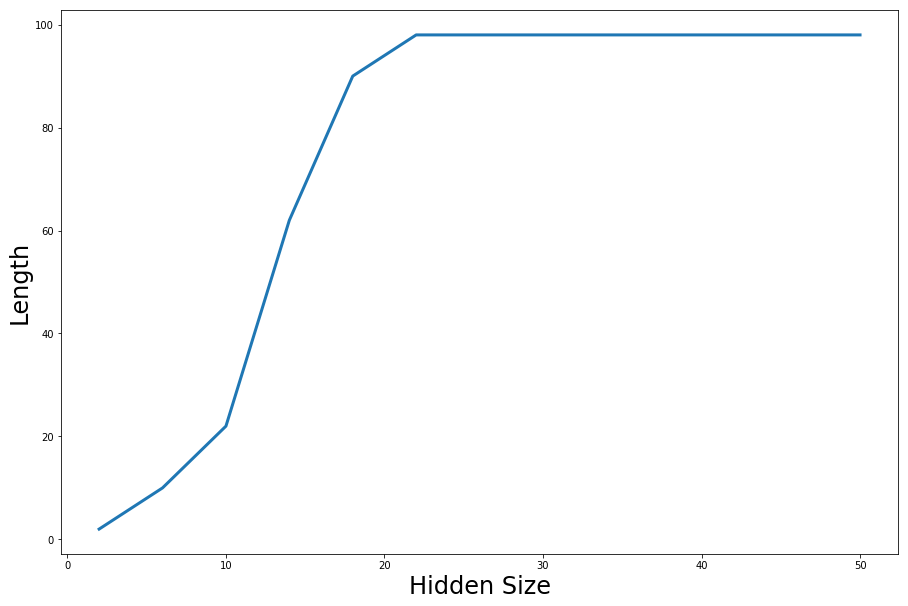

In [9]:
plt.figure(figsize=(15,10))
plt.plot(hidden_sizes, length_list, LineWidth=3)
plt.xlabel('Hidden Size', fontsize=24)
plt.ylabel('Length', fontsize=24)
plt.savefig('../../../log/plot/bracket_dedup_hidden_size_to_length/bracket_dedup_hidden_size_to_length.png')

In [10]:
print(hidden_sizes)
print(length_list)

[2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50]
[2, 10, 22, 62, 90, 98, 98, 98, 98, 98, 98, 98, 98]
